In [25]:
import xarray as xr
from pathlib import Path
import seaborn as sns
from sklearn import preprocessing
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn import linear_model, svm, neighbors, decomposition, metrics
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
from pvlib import irradiance

import matplotlib.pyplot as plt
from yellowbrick.classifier import class_prediction_error, classification_report, confusion_matrix

In [2]:
train_ds = xr.open_dataset('train_set.nc', engine='h5netcdf')

In [3]:
calipso_mask = (train_ds.cloud_layers != 0).astype(int).values

In [4]:
# et = irradiance.get_extra_radiation(pd.DatetimeIndex(train_ds.t.data)).values
# icor = (et * np.cos(np.radians(train_ds.solar_zenith))).data

In [5]:
vars_ = [v for v in train_ds.variables.keys() if 'CMI_C' in v] #+ ['solar_zenith', 'solar_azimuth', 'surface_elevation']
#vars_ = ['CMI_C02', 'CMI_C04', 'CMI_C05']
nears = list(range(4))
%time df = train_ds[vars_].isel(near=0).to_dataframe()
df = df.drop(columns=[c for c in df.columns if c not in vars_])
#df[[f'CMI_C0{v}' for v in (1, 2, 3, 5, 6, 7)]] = df[[f'CMI_C0{v}' for v in (1, 2, 3, 5, 6, 7)]].div(icor, axis=0)

CPU times: user 646 ms, sys: 28.9 ms, total: 675 ms
Wall time: 675 ms


In [6]:
X = df.dropna(axis=0, how='any')
y = calipso_mask[X.index]
X.shape, y.shape

((341267, 16), (341267,))

In [7]:
val_ds = xr.open_dataset('validate_set.nc', engine='h5netcdf')
#limit = (val_ds.cloud_type == 8) | (val_ds.cloud_type == 3)
# vet = irradiance.get_extra_radiation(pd.DatetimeIndex(val_ds.t.data)).values
# vcor = vet * np.cos(np.radians(val_ds.solar_zenith)).data
val_df = val_ds.sel(near=0)[vars_].to_dataframe()

val_df = val_df.drop(columns=[c for c in val_df.columns if c not in vars_])
#val_df[[f'CMI_C0{v}' for v in (1, 2, 3, 5, 6, 7)]] = val_df[[f'CMI_C0{v}' for v in (1, 2, 3, 5, 6, 7)]].div(vcor, axis=0)
val_nans = val_df.isna().any(axis=1)
X_val = val_df.dropna(axis=0, how='any')
y_val = (val_ds.cloud_layers != 0).values[X_val.index].astype(int)
X_val.shape, y_val.shape

((76693, 16), (76693,))

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [9]:
from lightgbm import LGBMClassifier, plot_importance, plot_split_value_histogram

In [10]:
clf = MLPClassifier(solver='adam', activation='relu', learning_rate='adaptive', alpha=1e-4, 
                    hidden_layer_sizes=(30, 20), max_iter=500, verbose=False)

model = Pipeline([
    ('scale', preprocessing.RobustScaler()),
    ('pca', decomposition.PCA(whiten=True)),
    ('clf', clf)
])
%time model.fit(X.values, y)

CPU times: user 51.4 s, sys: 438 ms, total: 51.9 s
Wall time: 51.4 s


Pipeline(memory=None,
         steps=[('scale',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(30, 20),
                               learning_rate='adaptive',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=500, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_

In [11]:
model.score(X, y), model.score(X_val, y_val)

(0.8889432614345952, 0.8848786721082759)

In [12]:
def cloud_detection_by_type(type_):
    limit = (val_ds.cloud_type == type_) | (val_ds.cloud_type == 8)
    X_val = val_df[limit.data].dropna(axis=0, how='any')
    y_val = (val_ds.cloud_layers != 0).values[X_val.index].astype(int)

    pred = model.predict(X_val)
    fn = pred[(y_val == 1) & (pred == 0)].shape[0]
    fp = pred[(y_val == 0) & (pred == 1)].shape[0]
    tn = pred[(y_val == 0) & (pred == 0)].shape[0]
    tp = pred[((y_val == 1) & (pred == 1))].shape[0]
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    flag = val_ds.cloud_type.flag_meanings[type_]
    print(f'{flag:25s} FN: {str(fn):5s}  TP: {str(tp):5s} TPR: {tpr:0.3f}')

for i in range(8):
    cloud_detection_by_type(i)

low overcast, transparent FN: 1      TP: 121   TPR: 0.992
low overcast, opaque      FN: 18     TP: 1061  TPR: 0.983
transition, stratocumulus FN: 150    TP: 1777  TPR: 0.922
low, broken cumulus       FN: 398    TP: 586   TPR: 0.596
altocumulus (transparent) FN: 1333   TP: 3736  TPR: 0.737
altostratus (opaque)      FN: 245    TP: 4692  TPR: 0.950
cirrus (transparent)      FN: 1454   TP: 15000 TPR: 0.912
deep convective (opaque)  FN: 22     TP: 9567  TPR: 0.998


/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CPU times: user 613 ms, sys: 440 ms, total: 1.05 s
Wall time: 353 ms


/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe2449be80>,
                     classes=None,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7fbe2440b780>,
                     encoder=None, force_model=False, is_fitted='auto',
                     model=None, support=None)

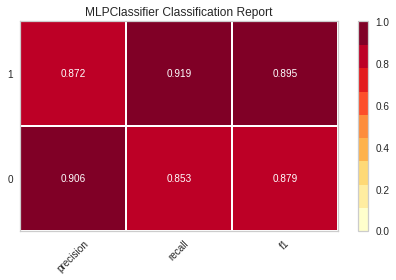

In [13]:
%matplotlib inline
%time classification_report(model, X, y)

CPU times: user 339 ms, sys: 307 ms, total: 647 ms
Wall time: 131 ms


/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe2436a7f0>,
                     classes=None,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7fbe243014e0>,
                     encoder=None, force_model=False, is_fitted='auto',
                     model=None, support=None)

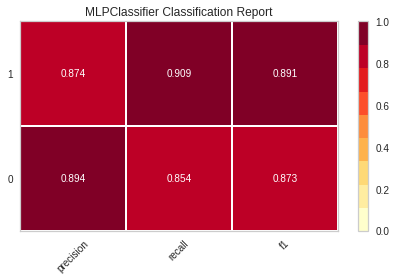

In [14]:
%matplotlib inline
%time classification_report(model, X_val, y_val)

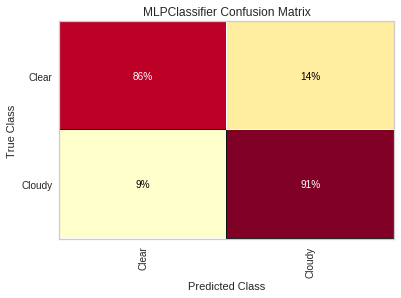

In [15]:
%matplotlib inline
cm = confusion_matrix(model, X_val, y_val, encoder={0: 'Clear', 1: 'Cloudy'}, percent=True, is_fitted=True)

In [17]:
import pickle
with open('cloud_mask.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
y_goes_alg = val_ds.BCM.isel(near=0).data[~val_nans].astype(int)
class GOESBCM(BaseEstimator, ClassifierMixin):
    name = 'fake'
    def predict(self, X):
        out = np.take(y_goes_alg, X[:, 0]).astype(int)
        out[out < 0] = 0
        return out
    
Xt = np.tile(np.arange(X_val.shape[0])[:, None], X_val.shape[1])

In [138]:
from itertools import product
def plot_confusion(y_true, y_pred, ax, vmax=0.51, labels=[0, 1], normalize='all', 
                   display_labels=['Clear', 'Cloudy']):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    cmap = plt.cm.Blues
    n_classes = cm.shape[0]
    im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=vmax)

    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)

    text_ = np.empty_like(cm, dtype=object)
    values_format = '.2g'

    # print text with appropriate color depending on background
    thresh = (cm.max() + cm.min()) / 2.0
    for i, j in product(range(n_classes), range(n_classes)):
        color = cmap_max if cm[i, j] < thresh else cmap_min
        text_[i, j] = ax.text(j, i,
                              format(cm[i, j], values_format),
                              ha="center", va="center",
                              color=color)

    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")
    ax.grid(False)
    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation='horizontal')
    return im_

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


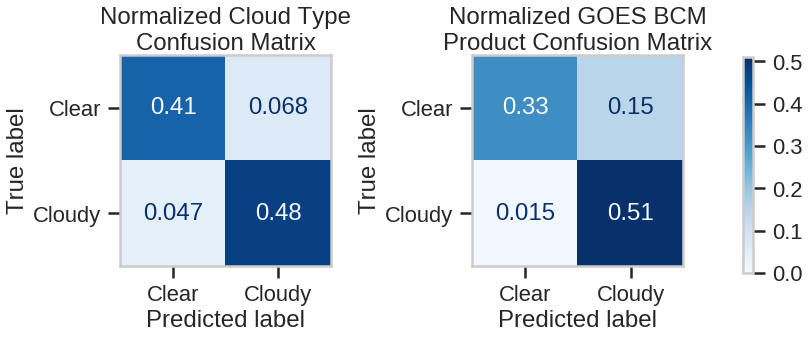

In [205]:
import seaborn as sns
with sns.plotting_context('poster'):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(131)
    plot_confusion(y_val, model.predict(X_val), ax)
    ax.set_title('Normalized Cloud Type\nConfusion Matrix')
    
    ax1 = fig.add_subplot(132)
    im_ = plot_confusion(y_val, y_goes_alg, ax1)
    ax1.set_title('Normalized GOES BCM\nProduct Confusion Matrix') 
    #plt.subplots_adjust(left=0.2, right=0.9, top=0.8, bottom=0.2)  # shrink fig so cbar is visible

    
    cbar_ax = fig.add_axes([0.62, 0.26, .1, 0.5])  # x, y, width, height
    cbar_ax.grid(False)
    cbar_ax.set_frame_on(False)
    cbar_ax.axis('off')
    fig.colorbar(im_, ax=cbar_ax, ticks=[0, .1, .2, .3, .4, 0.5])
    fig.tight_layout()
    fig.savefig('cloud_mask_confusion.png', dpi=300)

In [129]:
a

{'monochrome': False,
 'name': 'Blues',
 'N': 256,
 '_rgba_bad': (0.0, 0.0, 0.0, 0.0),
 '_rgba_under': None,
 '_rgba_over': None,
 '_i_under': 256,
 '_i_over': 257,
 '_i_bad': 258,
 '_isinit': True,
 'colorbar_extend': False,
 '_segmentdata': {'red': [(0.0, 0.9686274509803922, 0.9686274509803922),
   (0.125, 0.8705882352941177, 0.8705882352941177),
   (0.25, 0.7764705882352941, 0.7764705882352941),
   (0.375, 0.6196078431372549, 0.6196078431372549),
   (0.5, 0.4196078431372549, 0.4196078431372549),
   (0.625, 0.25882352941176473, 0.25882352941176473),
   (0.75, 0.12941176470588237, 0.12941176470588237),
   (0.875, 0.03137254901960784, 0.03137254901960784),
   (1.0, 0.03137254901960784, 0.03137254901960784)],
  'green': [(0.0, 0.984313725490196, 0.984313725490196),
   (0.125, 0.9215686274509803, 0.9215686274509803),
   (0.25, 0.8588235294117647, 0.8588235294117647),
   (0.375, 0.792156862745098, 0.792156862745098),
   (0.5, 0.6823529411764706, 0.6823529411764706),
   (0.625, 0.572549019

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


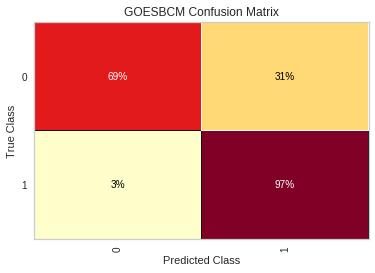

In [19]:

cm = confusion_matrix(GOESBCM(), Xt, y_val, is_fitted=True, percent=True)

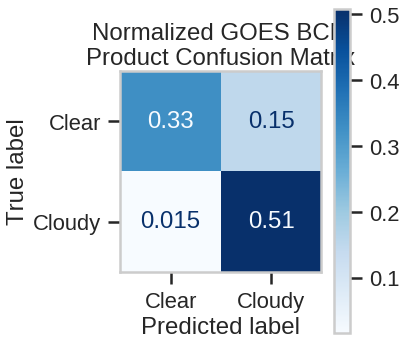

In [111]:
with sns.plotting_context('poster'):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    plot_confusion_matrix(GOESBCM(), Xt, y_val,
                             display_labels=['Clear', 'Cloudy'],
                             cmap=plt.cm.Blues,
                             normalize='all',
                          ax=ax)
    ax.grid(False)
    ax.set_title('Normalized GOES BCM\nProduct Confusion Matrix')

    fig.tight_layout()
    fig.savefig('BCM_confusion.png', dpi=300)